## Introduction
The dataset has been obtained by sampling and adapting the original dataset from Kaggle. Each row in the dataset corresponds to a different individual. Some columns are the answers to questions asked to respondents about their health status, such as "Do you have serious difficulty walking or climbing stairs?" or "Have you smoked at least 100 cigarettes in your entire life? The target is the Heart Disease variable, which indicates whether respondents that have ever reported having coronary heart disease (CHD) or myocardial infarction.

## Assignment
The implementation of a ML model to predict a person’s probability of having heart disease. Your work must include all stages of the ML Checklist (data understanding, data preparation, modelling and evaluation) in a notebook format. Your code is expected to be properly organized and commented to facilitate understanding, and it needs to run without errors. Different algorithms can be optionally explored as well.

In [503]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from sklearn import preprocessing
from sklearn import metrics
from sklearn import model_selection
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

Setup

In [504]:
plt.style.use('ggplot')
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
#pd.set_option('display.width', 1000)
%matplotlib inline
plt.style.use('ggplot')
pd.set_option('display.max_rows', 500)

Load data

In [505]:
df = pd.read_csv("heart_disease_project_data/heart_disease_data.csv")

## Data Understanding

Statistics

In [506]:
df.describe().T

count       mean       std    min    25%    50%    75%  \
BMI             319795.0  28.327367  6.369381  12.02  24.03  27.34  31.44   
PhysicalHealth  319795.0   3.371710  7.950850   0.00   0.00   0.00   2.00   
MentalHealth    319795.0   3.898366  7.955235   0.00   0.00   0.00   3.00   
SleepTime       319795.0   7.097075  1.436007   1.00   6.00   7.00   8.00   

                  max  
BMI             119.0  
PhysicalHealth   30.0  
MentalHealth     30.0  
SleepTime        24.0

Columns and data types

In [507]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 319795 entries, 0 to 319794
Data columns (total 20 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   HeartDisease                319795 non-null  object 
 1   BMI                         319795 non-null  float64
 2   Smoking                     319795 non-null  object 
 3   AlcoholDrinking             212984 non-null  object 
 4   Stroke                      318683 non-null  object 
 5   PhysicalHealth              319795 non-null  float64
 6   MentalHealth                319795 non-null  float64
 7   DiffWalking                 319795 non-null  object 
 8   Sex                         319795 non-null  object 
 9   AgeCategory                 319795 non-null  object 
 10  Race                        319795 non-null  object 
 11  Diabetic                    319795 non-null  object 
 12  PhysicalActivity            319795 non-null  object 
 13  GenHealth     

Columns with missing values

In [508]:
columns_with_missing_values = df.columns[df.isnull().any()]
columns_with_missing_values

Index(['AlcoholDrinking', 'Stroke', 'SkinCancer',
       'HeartDisease_FamilyHistory'],
      dtype='object')

In [509]:
df.dropna(inplace=True)

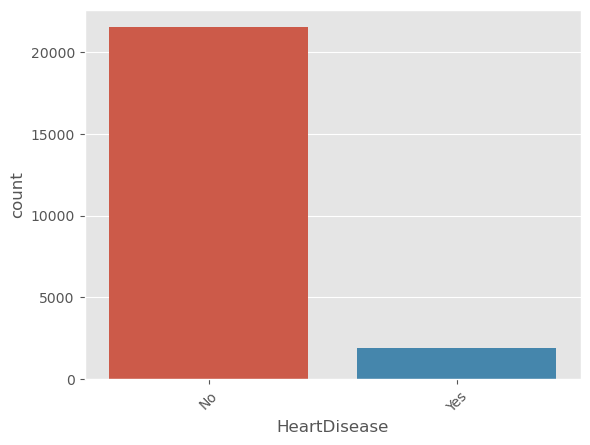

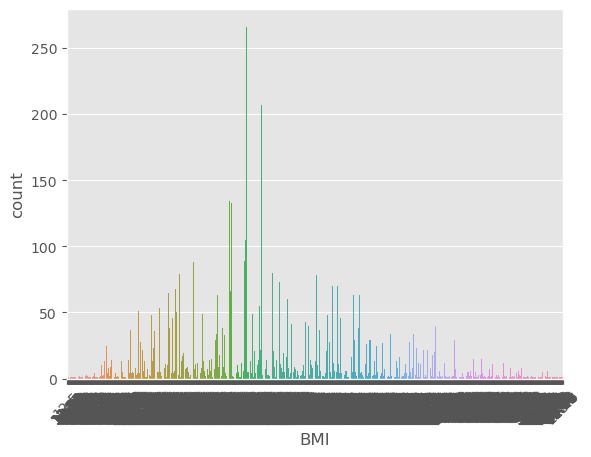

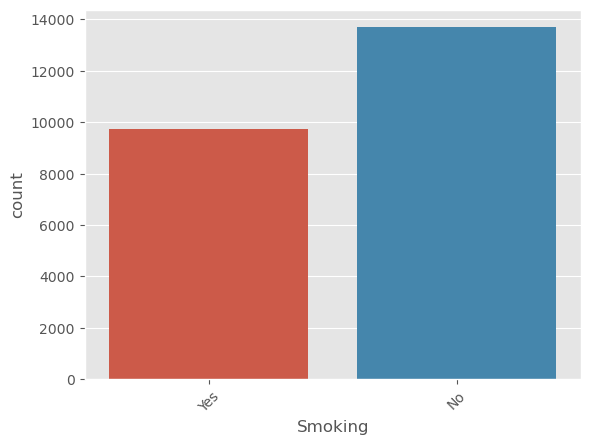

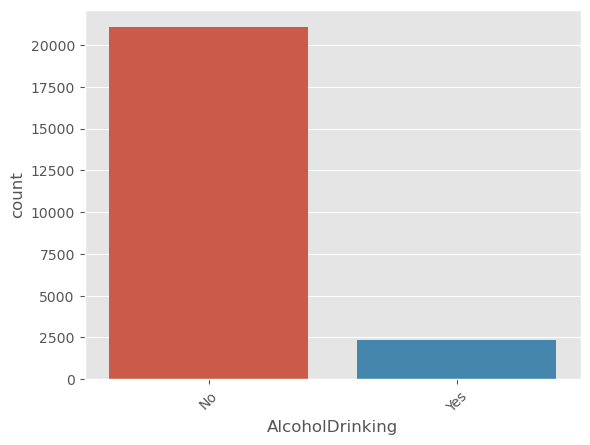

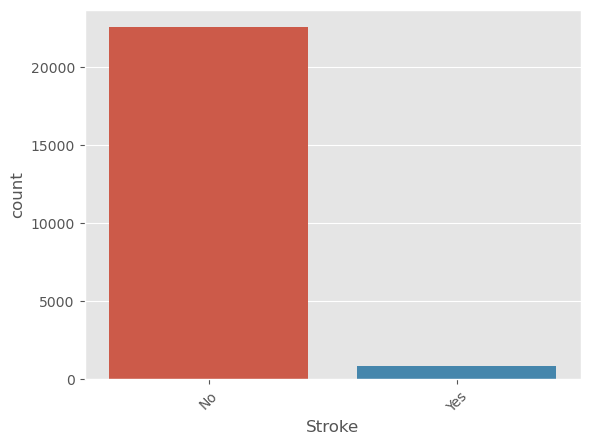

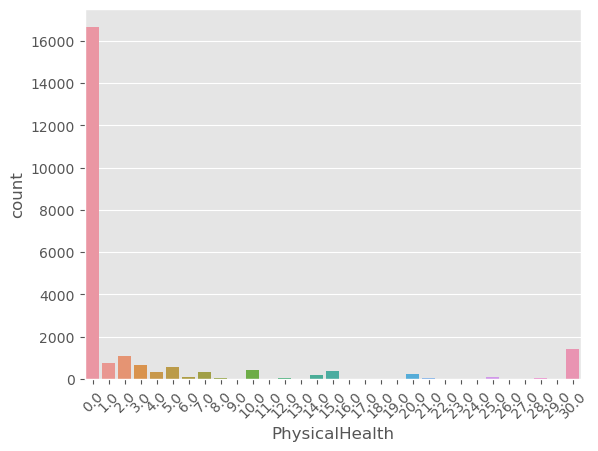

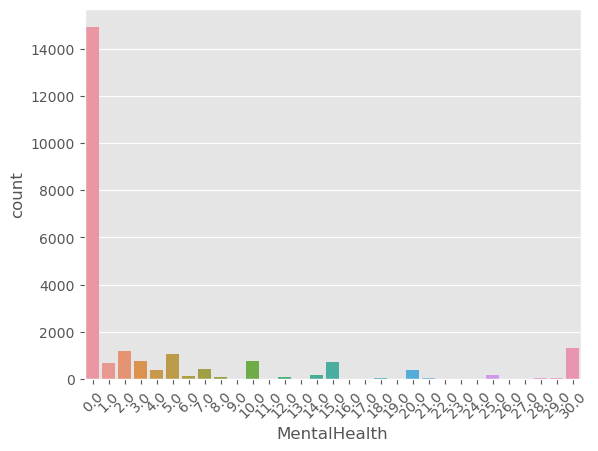

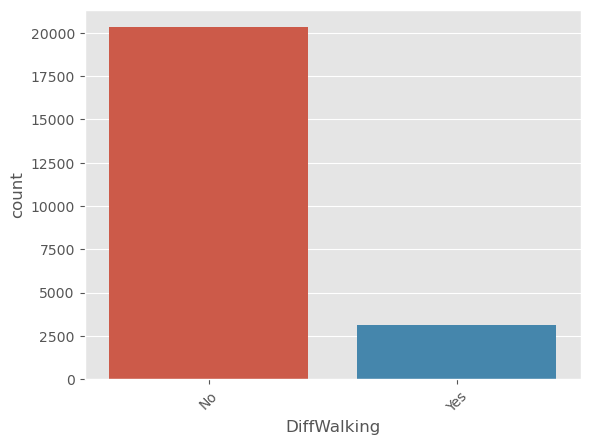

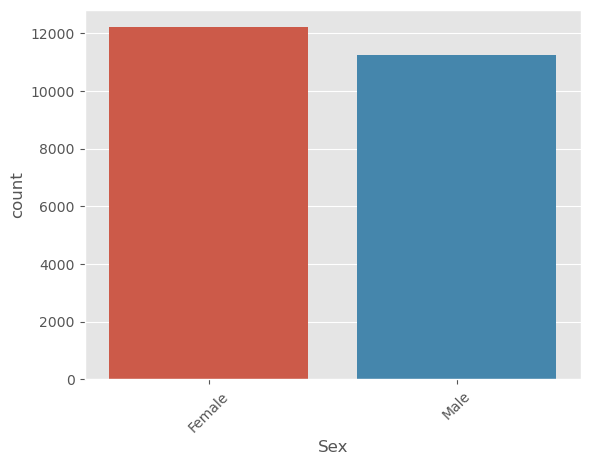

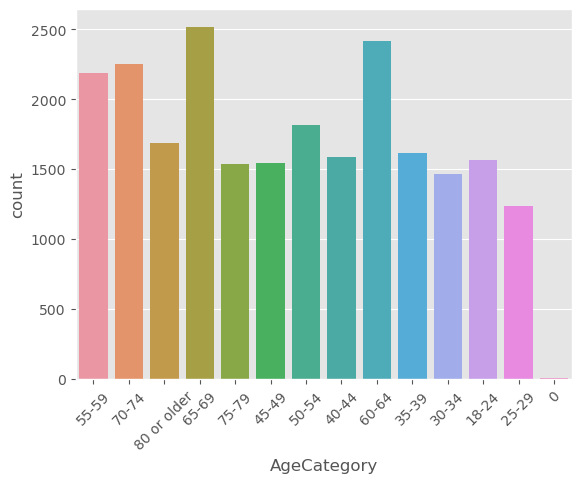

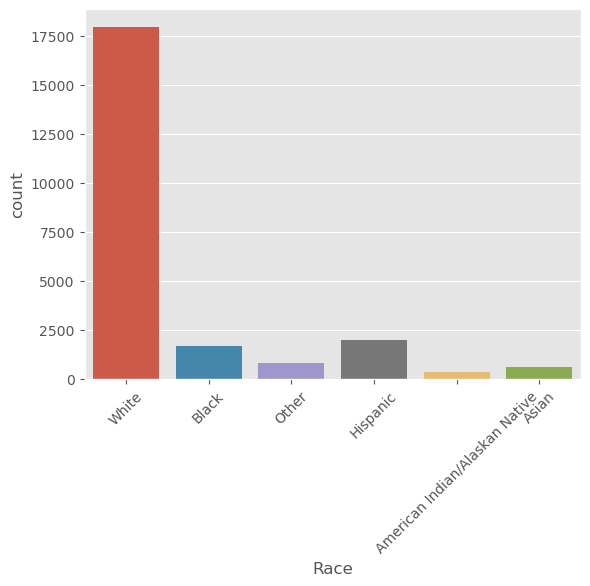

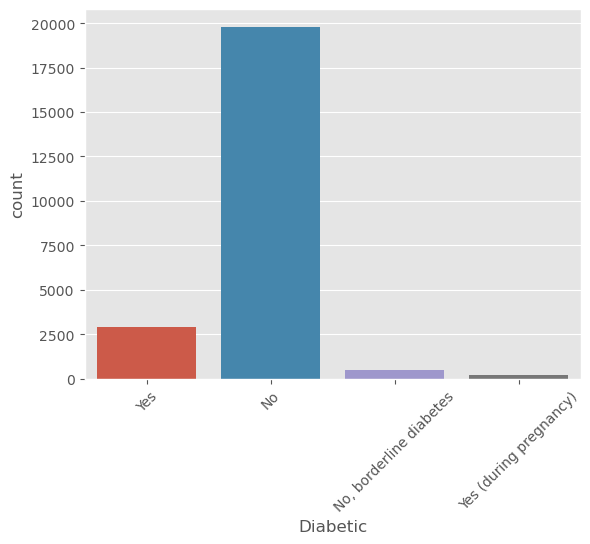

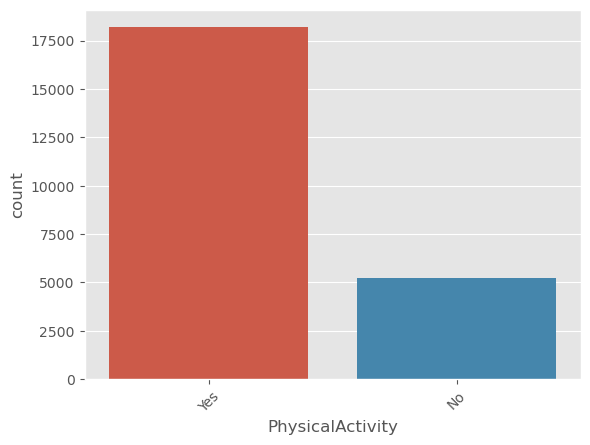

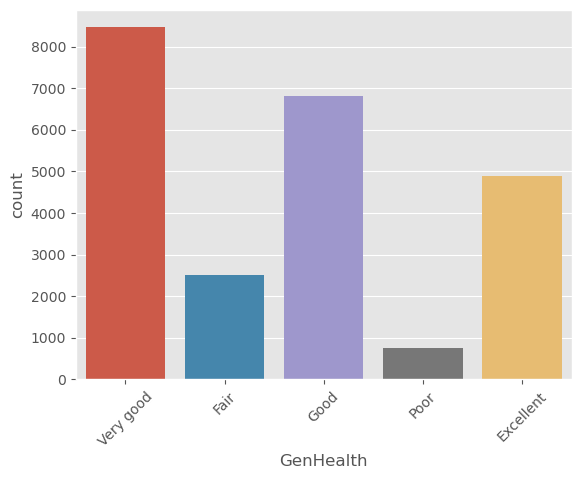

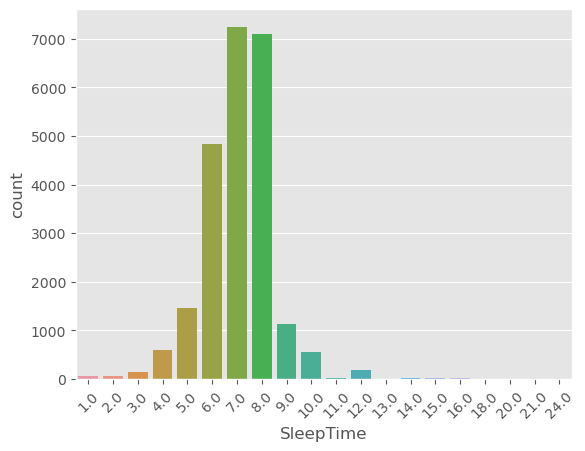

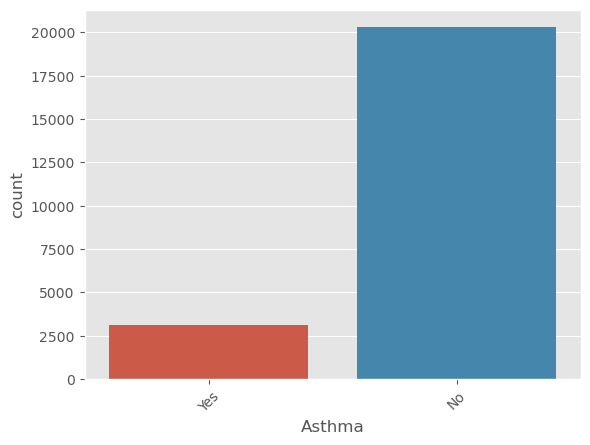

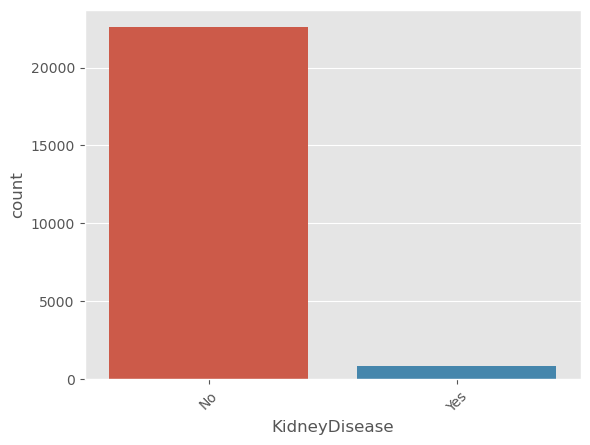

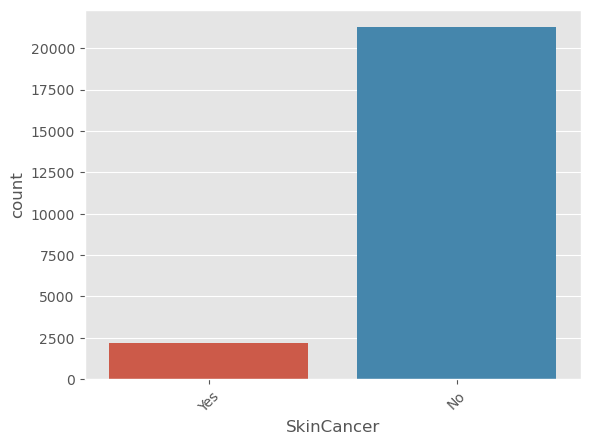

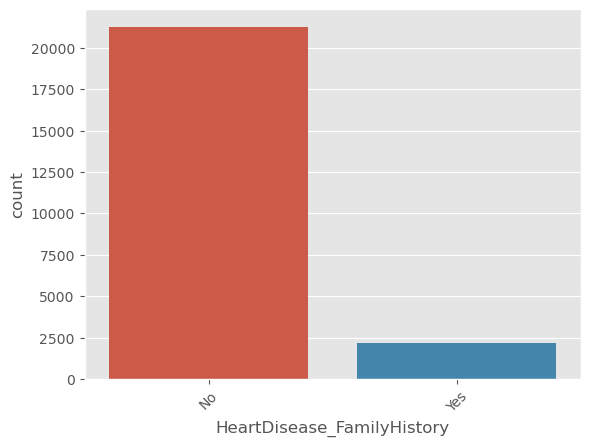

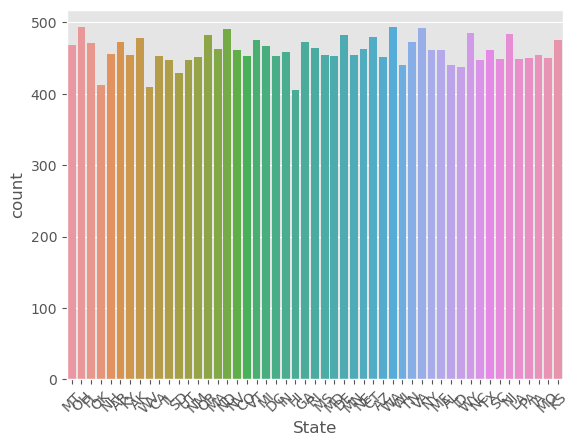

In [510]:
for column in df.columns:
    sns.countplot(data=df, x=column)
    plt.xticks(rotation=45)
    plt.show()

## Data prep and transformation

I notice we have some columns with binary data, so I converted to 0 and 1

In [511]:
binary_columns = df.columns[(df.nunique() == 2)]
binary_columns

Index(['HeartDisease', 'Smoking', 'AlcoholDrinking', 'Stroke', 'DiffWalking',
       'Sex', 'PhysicalActivity', 'Asthma', 'KidneyDisease', 'SkinCancer',
       'HeartDisease_FamilyHistory'],
      dtype='object')

In [512]:
df[binary_columns] = df[binary_columns].replace({"No": 0, "Yes": 1})

Looking to categorical columns

In [513]:
df.select_dtypes(include=['object']).describe().T

count unique        top   freq
Sex          23436      2     Female  12204
AgeCategory  23436     14      65-69   2518
Race         23436      6      White  17948
Diabetic     23436      4         No  19801
GenHealth    23436      5  Very good   8461
State        23436     51         WA    493

Looking for variables with low variance

In [514]:
df.apply(lambda x: x.nunique(), axis=0)

HeartDisease                     2
BMI                           1915
Smoking                          2
AlcoholDrinking                  2
Stroke                           2
PhysicalHealth                  31
MentalHealth                    31
DiffWalking                      2
Sex                              2
AgeCategory                     14
Race                             6
Diabetic                         4
PhysicalActivity                 2
GenHealth                        5
SleepTime                       20
Asthma                           2
KidneyDisease                    2
SkinCancer                       2
HeartDisease_FamilyHistory       2
State                           51
dtype: int64

Applying one-hot-encodings on the categorical variable

In [515]:
def OHE(dataframe, column_name):
    dummy_dataset = pd.get_dummies(dataframe[column_name], prefix = column_name)
    dataframe = pd.concat([dataframe, dummy_dataset], axis = 1)
    dataframe.drop(column_name, axis = 1, inplace = True)
    del dummy_dataset
    
    return dataframe

df = OHE(df, 'Sex')
df = OHE(df, 'AgeCategory')
df = OHE(df, 'Race')
df = OHE(df, 'Diabetic')
df = OHE(df, 'GenHealth')
df = OHE(df, 'State')

Checking the correlation between 'HeartDisease' and other variables

In [516]:
correlation = df.corr()['HeartDisease']
correlation = correlation.drop('HeartDisease')
correlation = correlation.sort_values(ascending=False)
print(correlation)

Stroke                                 0.197372
DiffWalking                            0.195992
Diabetic_Yes                           0.185599
GenHealth_Poor                         0.182419
PhysicalHealth                         0.164452
GenHealth_Fair                         0.160013
KidneyDisease                          0.152359
AgeCategory_80 or older                0.134168
Smoking                                0.114482
AgeCategory_75-79                      0.089850
AgeCategory_70-74                      0.081334
SkinCancer                             0.078862
Sex_Male                               0.072299
BMI                                    0.068494
AgeCategory_65-69                      0.047259
Asthma                                 0.041399
Race_White                             0.039183
AgeCategory_60-64                      0.024117
MentalHealth                           0.023245
GenHealth_Good                         0.023237
State_MN                               0

In [517]:
filtered_correlation = correlation[correlation >= 0.1]
print(filtered_correlation)


Stroke                     0.197372
DiffWalking                0.195992
Diabetic_Yes               0.185599
GenHealth_Poor             0.182419
PhysicalHealth             0.164452
GenHealth_Fair             0.160013
KidneyDisease              0.152359
AgeCategory_80 or older    0.134168
Smoking                    0.114482
Name: HeartDisease, dtype: float64


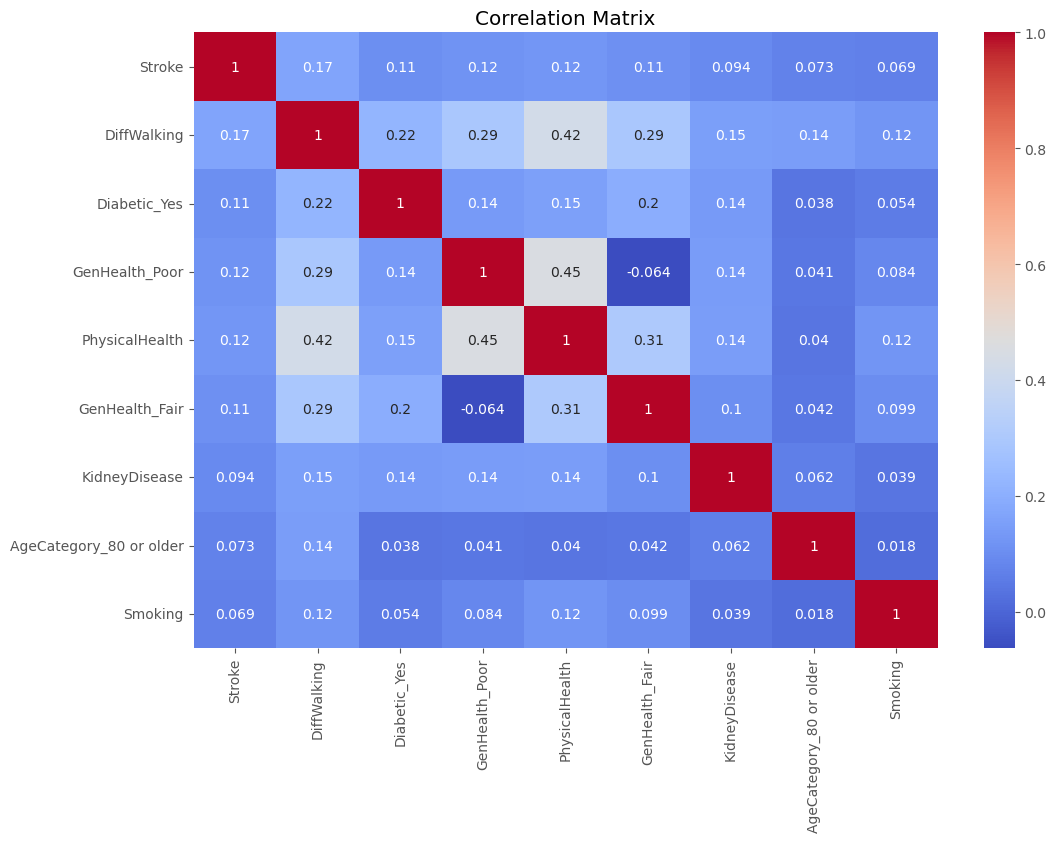

In [518]:
plt.figure(figsize=(12, 8))
sns.heatmap(df[filtered_correlation.index].corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()


In [519]:
df.head(5)

HeartDisease    BMI  Smoking  AlcoholDrinking  Stroke  PhysicalHealth  \
0               0  16.60        1                0       0             3.0   
39              0  21.93        0                0       0             3.0   
48              0  20.12        0                0       0             0.0   
96              0  24.02        0                0       0             0.0   
101             1  24.68        1                0       0            30.0   

     MentalHealth  DiffWalking  PhysicalActivity  SleepTime  Asthma  \
0            30.0            0                 1        5.0       1   
39            2.0            0                 1        4.0       0   
48            0.0            1                 0        7.0       0   
96           14.0            0                 1        7.0       0   
101          30.0            1                 1        8.0       0   

     KidneyDisease  SkinCancer  HeartDisease_FamilyHistory  Sex_Female  \
0                0           1                           0        True   
39               1           0                           1        True   
48               0           1                           0        True   
96               0           1                           0        True   
101              0           1                           0       False   

     Sex_Male  AgeCategory_0  AgeCategory_18-24  AgeCategory_25-29  \
0       False          False              False              False   
39      False          False              False              False   
48      False          False              False              False   
96      False          False              False              False   
101      True          False              False              False   

     AgeCategory_30-34  AgeCategory_35-39  AgeCategory_40-44  \
0                False              False              False   
39               False              False              False   
48               False              False              False   
96               False              False              False   
101              False              False              False   

     AgeCategory_45-49  AgeCategory_50-54  AgeCategory_55-59  \
0                False              False               True   
39               False              False              False   
48               False              False              False   
96               False              False              False   
101              False              False              False   

     AgeCategory_60-64  AgeCategory_65-69  AgeCategory_70-74  \
0                False              False              False   
39               False              False               True   
48               False              False              False   
96               False              False               True   
101              False              False               True   

     AgeCategory_75-79  AgeCategory_80 or older  \
0                False                    False   
39               False                    False   
48               False                     True   
96               False                    False   
101              False                    False   

     Race_American Indian/Alaskan Native  Race_Asian  Race_Black  \
0                                  False       False       False   
39                                 False       False        True   
48                                 False       False       False   
96                                 False       False       False   
101                                False       False       False   

     Race_Hispanic  Race_Other  Race_White  Diabetic_No  \
0            False       False        True        False   
39           False       False       False         True   
48           False       False        True         True   
96           False       False        True         True   
101          False       False        True         True   

     Diabetic_No,

### Train/validation split  

In [520]:
# Split the dataset into features and target variable
X = df.drop(columns=['HeartDisease'])
y = df['HeartDisease'] 

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [521]:
dt = DecisionTreeClassifier(
                        # criterion='gini',
                        # splitter='best',
                        max_depth=4, # Important, regulate over-adjustment
                        # min_samples_split=2, # minimum number of observations in each split
                        # min_samples_leaf=1, # minimum number of observations in each leaf 
                        # min_weight_fraction_leaf=0.0,
                        # max_features=None,
                        random_state=42,
                        # max_leaf_nodes=None,
                        # min_impurity_decrease=0.0,
                        # min_impurity_split=None,
                        # class_weight=None,
                        # presort=False,  
                )

In [522]:
### Train model
dt.fit(
    X=X_train, 
    y=y_train, 
    # sample_weight=None, 
    # check_input=True, 
    # X_idx_sorted=None
)

DecisionTreeClassifier(max_depth=4, random_state=42)

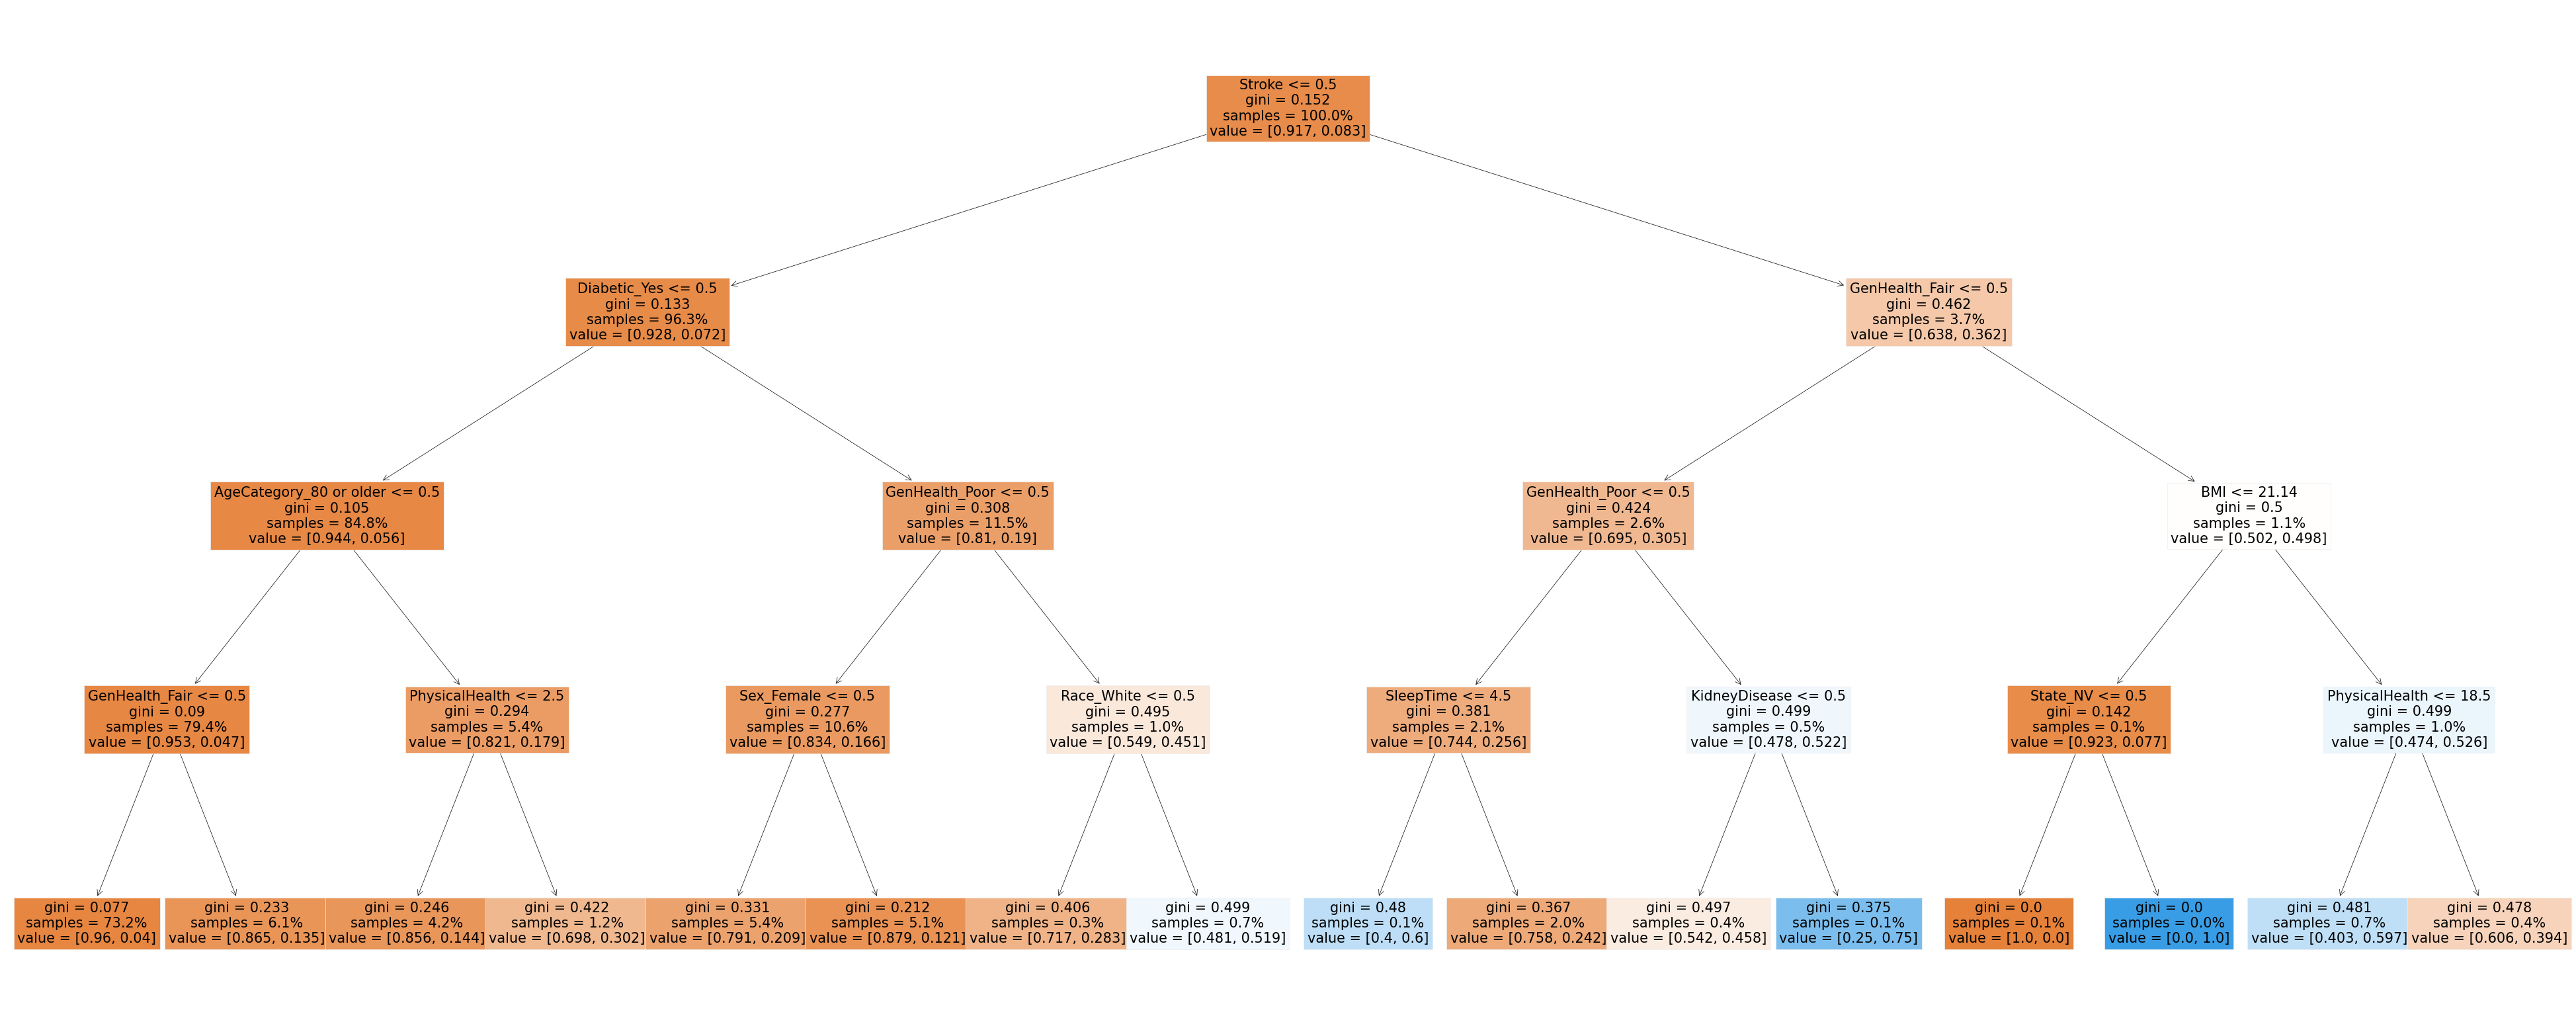

In [523]:
fig, ax = plt.subplots(figsize=(50,20))
tree.plot_tree(dt, 
               ax=ax, 
               fontsize=15,
               proportion=True,
               filled=True, 
               feature_names=list(X_test.columns));


From the visualization of the tree we can see that the most relevant variable is DiffWalking.

According with our data dictionay DiffWalking is:
> Do you have serious difficulty walking or climbing stairs?

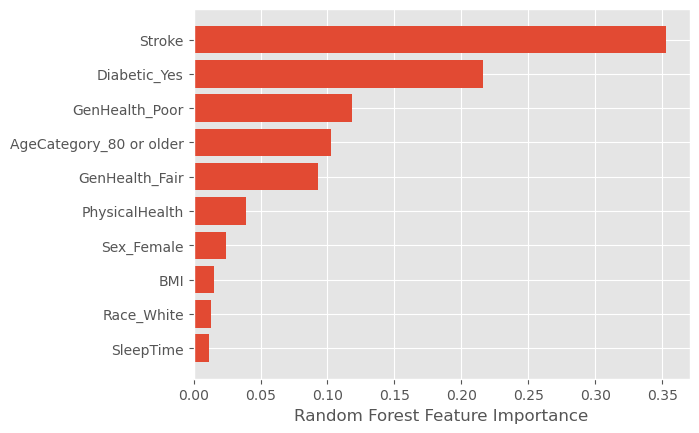

In [524]:
sorted_idx = dt.feature_importances_.argsort()
plt.barh(X_train.columns[sorted_idx][-10:], dt.feature_importances_[sorted_idx][-10:])
plt.xlabel("Random Forest Feature Importance")
plt.show()

Stroke is the main variable of the model.

### Model evaluation

#### Evaluation over train dataset

In [525]:
y_train_pred = pd.DataFrame(dt.predict(X_train), index=y_train.index, columns=['DelayPrediction'])
y_train_pred['DelayPrediction'].value_counts()

DelayPrediction
0    18459
1      289
Name: count, dtype: int64

In [526]:
y_train_pred = pd.DataFrame(dt.predict(X_train), index=y_train.index, columns=['DelayPrediction'])

In [527]:
results_df = pd.DataFrame(y_train).join(y_train_pred, how='inner')


In [528]:
results_df['Success'] = (results_df['HeartDisease'] == results_df['DelayPrediction']).astype(int)

In [529]:
results_df.head(10)

HeartDisease  DelayPrediction  Success
106601             0                0        1
228221             1                0        0
95274              0                0        1
94378              0                0        1
67930              0                0        1
205764             0                0        1
288275             0                0        1
1126               0                0        1
141055             0                0        1
185734             0                0        1

In [530]:
print('TRAIN - We have correctly predicted {} from a total of {}. The accuracy is {}.'.format(results_df['Success'].sum(), results_df['Success'].count(), results_df['Success'].mean()))

TRAIN - We have correctly predicted 17242 from a total of 18748. The accuracy is 0.9196714316193727.


It really seems that the model is doing an ok job. 
But are we being able to predict correctly Heart Disease?

#### Confusion matrix

In [531]:
confusion_matrix = pd.crosstab(results_df['HeartDisease'], results_df['DelayPrediction'])
confusion_matrix

DelayPrediction      0    1
HeartDisease               
0                17076  123
1                 1383  166

In [532]:
TP = confusion_matrix.iloc[1,1]
TN = confusion_matrix.iloc[0,0]
FP = confusion_matrix.iloc[0,1]
FN = confusion_matrix.iloc[1,0]

In [533]:
accuracy = (TP + TN) / (TP + TN + FP + FN)
accuracy

0.9196714316193727

In [534]:
Precision = TP / (TP+FP)
Recall = TP/(TP+FN)
print(Precision)
print(Recall)

0.5743944636678201
0.10716591349257586


#### Using the metrics module

In [535]:
confusion_matrix_m = metrics.confusion_matrix(results_df['HeartDisease'],results_df['DelayPrediction'])
Accuracy_m = metrics.accuracy_score(results_df['HeartDisease'], results_df['DelayPrediction'])
Precision_m = metrics.precision_score(results_df['HeartDisease'],results_df['DelayPrediction'])
Recall_m = metrics.recall_score(results_df['HeartDisease'],results_df['DelayPrediction'])

print("Confusion matrix: ", confusion_matrix_m)
print("Accuracy: ", Accuracy_m)
print("Precision: ", Precision_m)
print("Recall: ", Recall_m)

Confusion matrix:  [[17076   123]
 [ 1383   166]]
Accuracy:  0.9196714316193727
Precision:  0.5743944636678201
Recall:  0.10716591349257586


#### Using the model

In [536]:
dt.score(X_test, y_test)

0.9172354948805461

### Evaluation over test dataset

#### Get predictions for the test set

In [537]:
y_test_pred = pd.DataFrame(dt.predict(X_test), index=y_test.index, columns=['DelayPrediction'])

In [538]:
results_df_test = pd.merge(y_test, y_test_pred, left_index=True, right_index=True, how='inner')
results_df_test['Success'] = (results_df_test['HeartDisease'] == results_df_test['DelayPrediction']).astype(int)

In [539]:
confusion_matrix_m_test = metrics.confusion_matrix(results_df_test['HeartDisease'],results_df_test['DelayPrediction'])
Accuracy_m_test = metrics.accuracy_score(results_df_test['HeartDisease'], results_df_test['DelayPrediction'])
Precision_m_test = metrics.precision_score(results_df_test['HeartDisease'],results_df_test['DelayPrediction'])
Recall_m_test = metrics.recall_score(results_df_test['HeartDisease'],results_df_test['DelayPrediction'])

print("Confusion matrix: ", confusion_matrix_m_test)
print("Accuracy: ", Accuracy_m_test)
print("Precision: ", Precision_m_test)
print("Recall: ", Recall_m_test)

Confusion matrix:  [[4269   43]
 [ 345   31]]
Accuracy:  0.9172354948805461
Precision:  0.4189189189189189
Recall:  0.08244680851063829


### Model optimization

### Hyperparameter optimization

In [540]:
for i in range(1, 20):
    dt = DecisionTreeClassifier(max_depth=i, random_state=42)
    dt.fit(X_train, y_train)
    train_accuracy = dt.score(X_train, y_train)
    test_accuracy = dt.score(X_test, y_test)
    print('Tree max_depth: {}. Train: {} - Test: {}'.format(i, train_accuracy, test_accuracy))

Tree max_depth: 1. Train: 0.9173778536377214 - Test: 0.9197952218430034
Tree max_depth: 2. Train: 0.9173778536377214 - Test: 0.9197952218430034
Tree max_depth: 3. Train: 0.9181245999573288 - Test: 0.9206484641638225
Tree max_depth: 4. Train: 0.9196714316193727 - Test: 0.9172354948805461
Tree max_depth: 5. Train: 0.9211649242585875 - Test: 0.9197952218430034
Tree max_depth: 6. Train: 0.9226050778749734 - Test: 0.9185153583617748
Tree max_depth: 7. Train: 0.9262854704501814 - Test: 0.9146757679180887
Tree max_depth: 8. Train: 0.9307659483678259 - Test: 0.9136092150170648
Tree max_depth: 9. Train: 0.9361531896735652 - Test: 0.9072098976109215
Tree max_depth: 10. Train: 0.9410603797738425 - Test: 0.9082764505119454
Tree max_depth: 11. Train: 0.9457542137828036 - Test: 0.9072098976109215
Tree max_depth: 12. Train: 0.9506080648602517 - Test: 0.9061433447098977
Tree max_depth: 13. Train: 0.9556219330061874 - Test: 0.9050767918088737
Tree max_depth: 14. Train: 0.9610091743119266 - Test: 0.9016

### Model optimization

In [541]:
for i in range(1, 20):
    dt = DecisionTreeClassifier(max_depth=i, random_state=42, min_samples_split=40)
    dt.fit(X_train, y_train)
    train_accuracy = dt.score(X_train, y_train)
    test_accuracy = dt.score(X_test, y_test)
    print('Tree Depth: {}. Train: {} - Test: {}'.format(i, train_accuracy, test_accuracy))

Tree Depth: 1. Train: 0.9173778536377214 - Test: 0.9197952218430034
Tree Depth: 2. Train: 0.9173778536377214 - Test: 0.9197952218430034
Tree Depth: 3. Train: 0.9181245999573288 - Test: 0.9206484641638225
Tree Depth: 4. Train: 0.9196180925965436 - Test: 0.9172354948805461
Tree Depth: 5. Train: 0.9209515681672712 - Test: 0.9195819112627986
Tree Depth: 6. Train: 0.9219650096010241 - Test: 0.91830204778157
Tree Depth: 7. Train: 0.9240452314913591 - Test: 0.9153156996587031
Tree Depth: 8. Train: 0.9258054192447195 - Test: 0.9121160409556314
Tree Depth: 9. Train: 0.9273522509067634 - Test: 0.9108361774744027
Tree Depth: 10. Train: 0.9288457435459783 - Test: 0.9099829351535836
Tree Depth: 11. Train: 0.9304459142308513 - Test: 0.9082764505119454
Tree Depth: 12. Train: 0.9315126946874334 - Test: 0.9074232081911263
Tree Depth: 13. Train: 0.9325261361211863 - Test: 0.9055034129692833
Tree Depth: 14. Train: 0.9332728824407936 - Test: 0.9048634812286689
Tree Depth: 15. Train: 0.9340729677832302 - T

In [542]:
dt = DecisionTreeClassifier(max_depth=11, random_state=42, min_samples_split=50)
dt.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=11, min_samples_split=50, random_state=42)

In [543]:
dt.score(X_train, y_train)

0.9291124386601237

In [544]:
dt.score(X_test, y_test)

0.9089163822525598

#### F1 score

In [546]:
results_df_test = pd.merge(y_test, y_test_pred, left_index=True, right_index=True, how='inner')

In [547]:
confusion_matrix_m_test = metrics.confusion_matrix(results_df_test['HeartDisease'],results_df_test['DelayPrediction'])
Accuracy_m_test = metrics.accuracy_score(results_df_test['HeartDisease'], results_df_test['DelayPrediction'])
Precision_m_test = metrics.precision_score(results_df_test['HeartDisease'],results_df_test['DelayPrediction'])
Recall_m_test = metrics.recall_score(results_df_test['HeartDisease'],results_df_test['DelayPrediction'])
f1_m_test = metrics.f1_score(results_df_test['HeartDisease'],results_df_test['DelayPrediction'])

print("Confusion matrix: ", confusion_matrix_m_test)
print("Accuracy: ", Accuracy_m_test)
print("Precision: ", Precision_m_test)
print("Recall: ", Recall_m_test)
print("F1 Score: ", f1_m_test)

Confusion matrix:  [[4220   92]
 [ 335   41]]
Accuracy:  0.9089163822525598
Precision:  0.3082706766917293
Recall:  0.10904255319148937
F1 Score:  0.16110019646365423


#### ROC curve

In [548]:
print(metrics.roc_auc_score(results_df_test['HeartDisease'], results_df_test['DelayScore']))

0.7825911977460229


In [549]:
fpr, tpr, _ = metrics.roc_curve(results_df_test['HeartDisease'], results_df_test['DelayScore'])

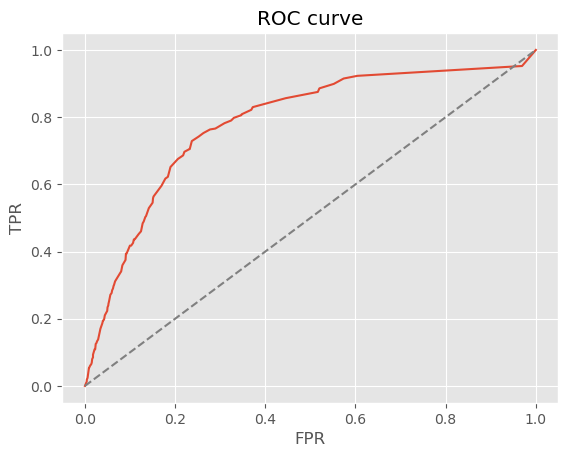

In [550]:
plt.clf()
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC curve')
plt.show()

#### K-fold validation strategy

In [551]:
kf = model_selection.KFold(n_splits=10, random_state=42, shuffle=True)

In [554]:
dt = DecisionTreeClassifier(max_depth=8, random_state=42)
scores = model_selection.cross_val_score(dt, dev_df_X, dev_df_y, cv=kf)
scores

array([0.92022184, 0.91595563, 0.90230375, 0.91552901, 0.92491468,
       0.91424915, 0.90439607, 0.91933419, 0.91976099, 0.91591976])

In [555]:
print("Accuracy: %0.3f (+/- %0.3f)" % (scores.mean(), scores.std() * 2))

Accuracy: 0.915 (+/- 0.013)


In [556]:
scores_list = []
for train_index, test_index in kf.split(df):
    #print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = dev_df_X.iloc[train_index], dev_df_X.iloc[test_index]
    y_train, y_test = dev_df_y.iloc[train_index], dev_df_y.iloc[test_index]
    dt = DecisionTreeClassifier(max_depth=8, random_state=42)
    dt.fit(X_train, y_train)
    _score = dt.score(X_test, y_test)
    scores_list.append(_score)
    #print(_scores)
scores_list

[0.9202218430034129,
 0.9159556313993175,
 0.9023037542662116,
 0.9155290102389079,
 0.9249146757679181,
 0.9142491467576792,
 0.9043960734101579,
 0.9193341869398207,
 0.9197609901835254,
 0.9159197609901836]

In [557]:
np.mean(scores_list)

0.9152585072957133

In [558]:
np.std(scores_list)

0.006652767263350643

### ENSEMBLE MODELS (alternative models)

Ensemble models are an alternative to the classic decision trees that we have been using. They'll help us to reach a higher precision also enhancing its generalization ability. We will test Random Forest and Gradient Boosting algorithms for our current problem

In [559]:
rf = RandomForestClassifier(n_estimators=3, max_depth=5, random_state=42)

In [560]:
rf.fit(
    X=X_train, 
    y=np.ravel(y_train)
)

RandomForestClassifier(max_depth=5, n_estimators=3, random_state=42)

In [561]:
tree_list = rf.estimators_
tree_list

[DecisionTreeClassifier(max_depth=5, max_features='sqrt',
                        random_state=1608637542),
 DecisionTreeClassifier(max_depth=5, max_features='sqrt',
                        random_state=1273642419),
 DecisionTreeClassifier(max_depth=5, max_features='sqrt',
                        random_state=1935803228)]

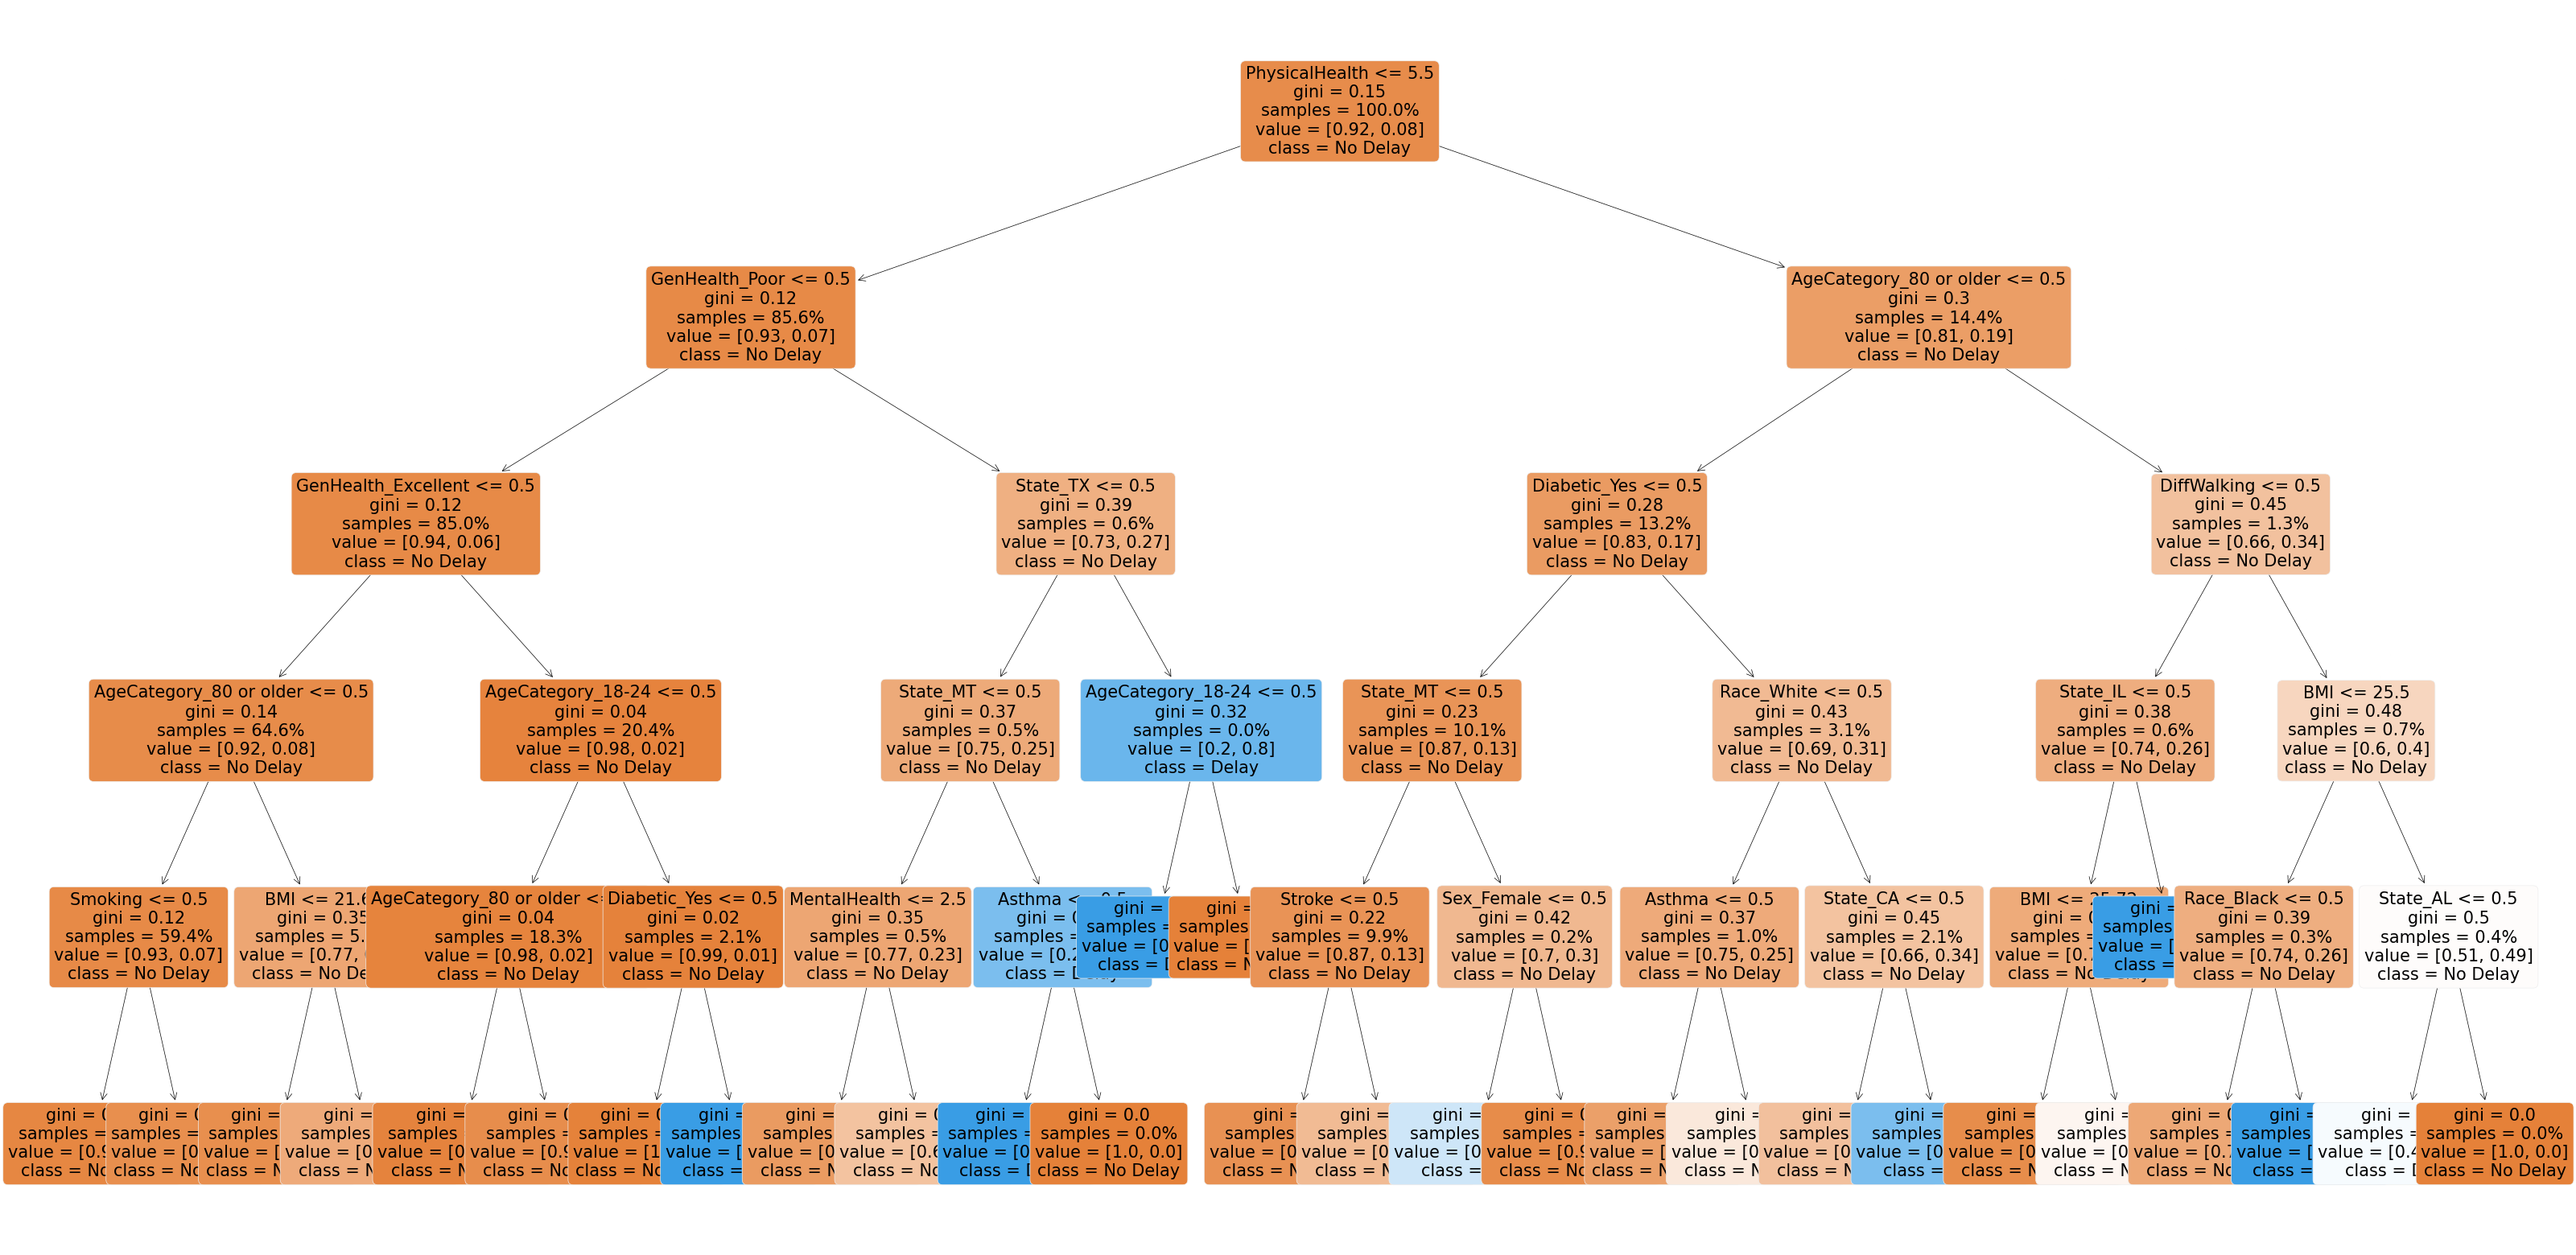

In [562]:
fig, ax = plt.subplots(figsize=(40,20))
tree.plot_tree(tree_list[0], 
               ax=ax, 
               fontsize=15,
               proportion=True,
               filled=True, 
               impurity=True,
               rounded=True,
               precision=2,
               class_names=['No Delay', 'Delay'],
               feature_names=list(X_test.columns));

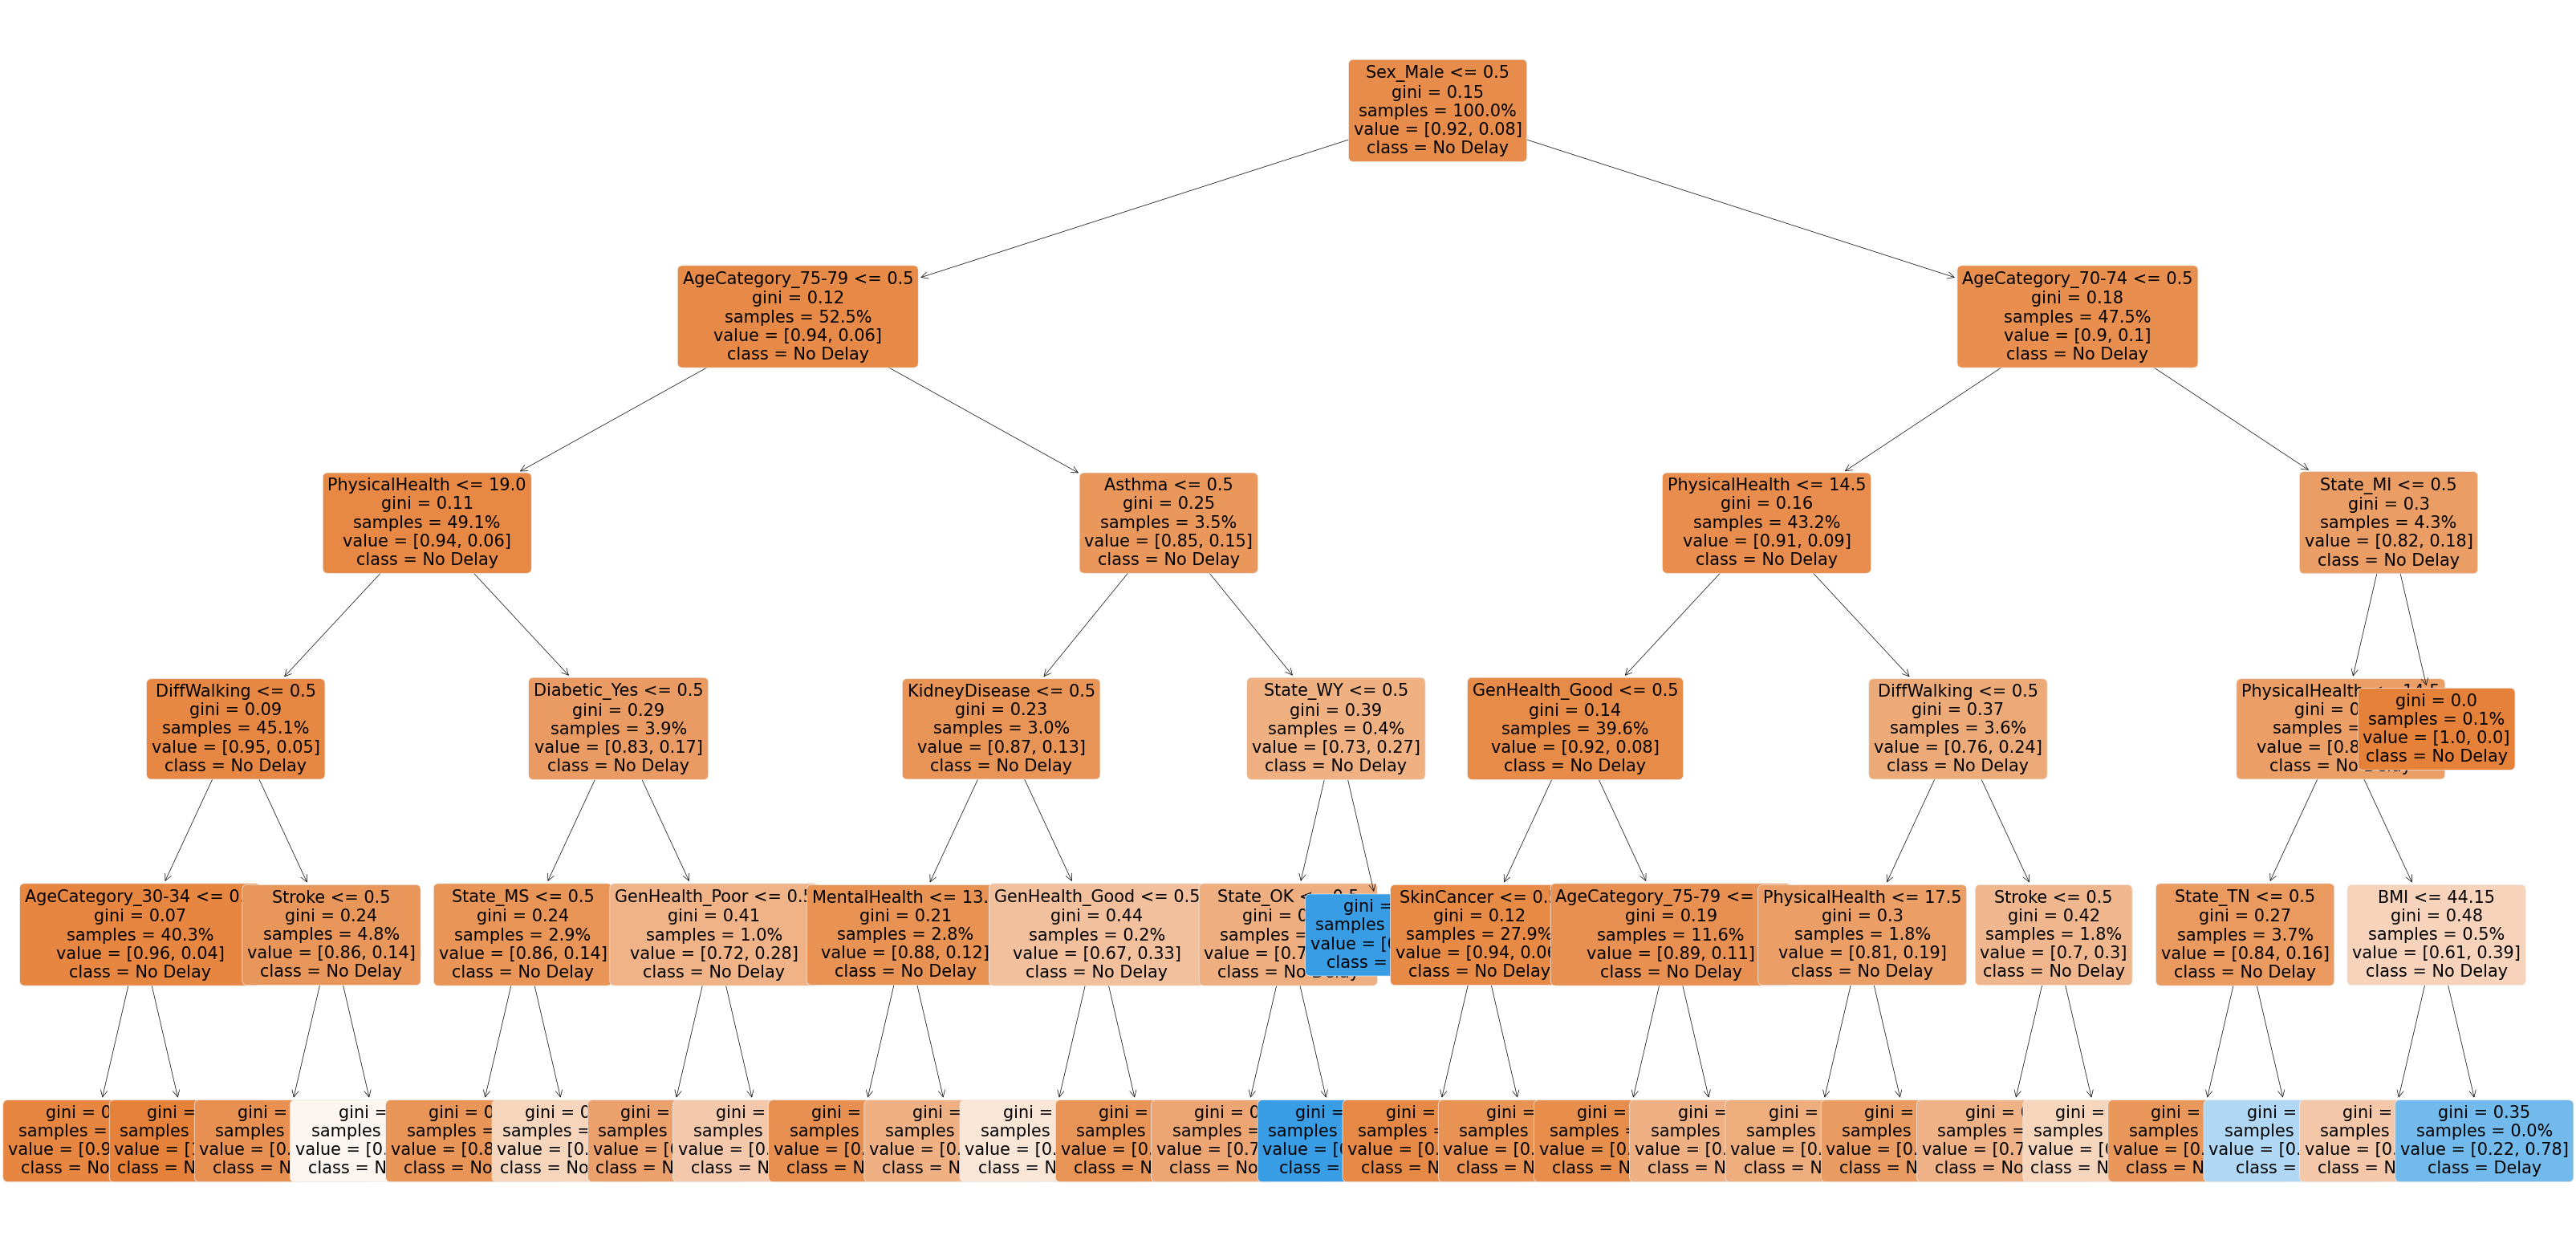

In [563]:
fig, ax = plt.subplots(figsize=(40,20))
tree.plot_tree(tree_list[1], 
               ax=ax, 
               fontsize=15,
               proportion=True,
               filled=True, 
               impurity=True,
               rounded=True,
               precision=2,
               class_names=['No Delay', 'Delay'],
               feature_names=list(X_test.columns));

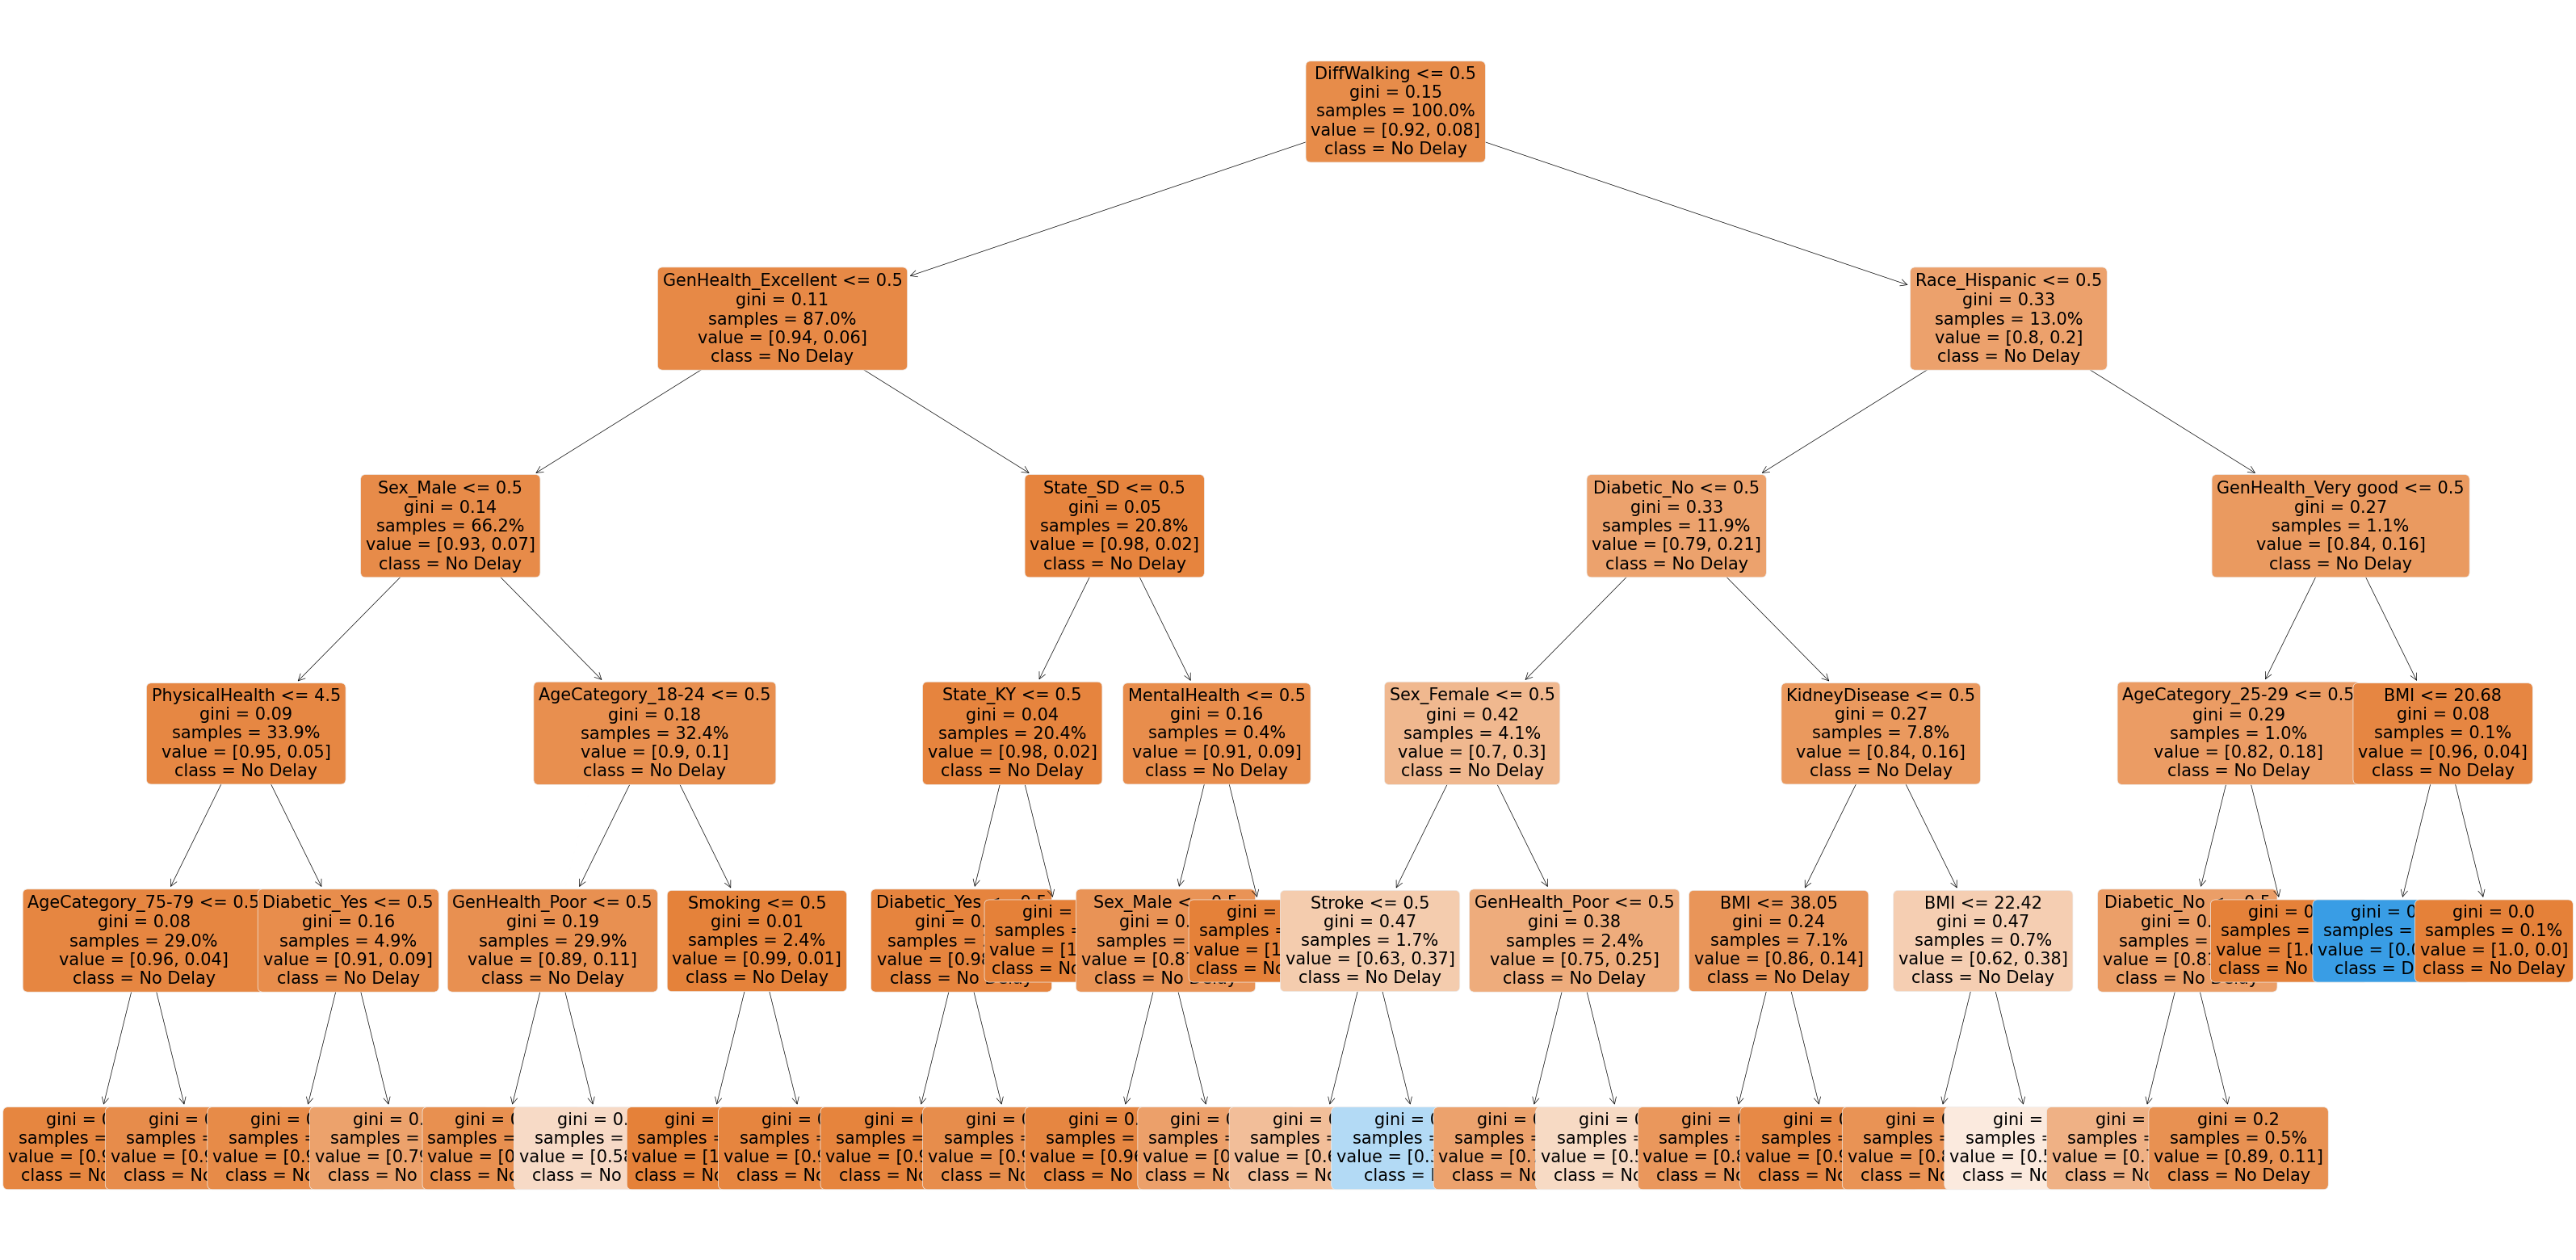

In [564]:
fig, ax = plt.subplots(figsize=(40,20))
tree.plot_tree(tree_list[2], 
               ax=ax, 
               fontsize=15,
               proportion=True,
               filled=True, 
               impurity=True,
               rounded=True,
               precision=2,
               class_names=['No Delay', 'Delay'],
               feature_names=list(X_test.columns));

But if we want to understand the importance of each future to the ensemble, we can use the **feature_importance** method, which averages the information gain of the predictor across the whole ensemble.  

In [565]:
top_features = pd.Series(rf.feature_importances_, index=X_train.columns).sort_values(ascending=False).head(20)
top_features

PhysicalHealth             0.202844
DiffWalking                0.168383
AgeCategory_80 or older    0.076666
Stroke                     0.059129
Diabetic_Yes               0.058200
GenHealth_Poor             0.051060
GenHealth_Excellent        0.047493
Sex_Male                   0.047082
BMI                        0.038489
AgeCategory_75-79          0.037706
Diabetic_No                0.034212
KidneyDisease              0.025616
AgeCategory_70-74          0.021016
Smoking                    0.020029
AgeCategory_18-24          0.015846
Sex_Female                 0.014038
GenHealth_Good             0.012183
Asthma                     0.010735
State_TN                   0.010426
State_OK                   0.006785
dtype: float64

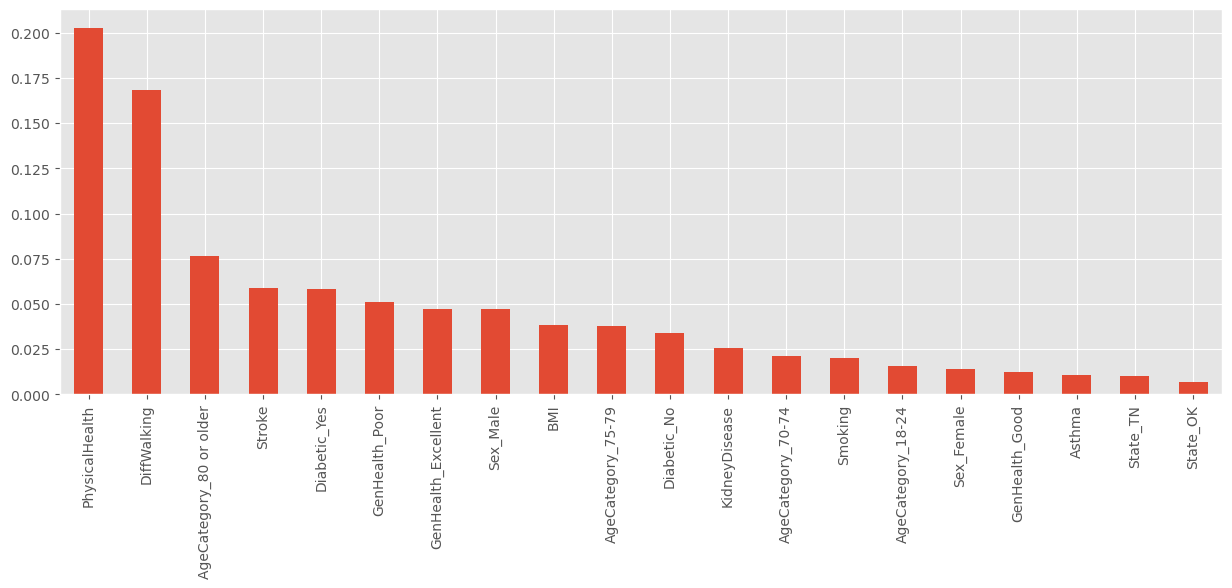

In [579]:
plt.figure(figsize=(15,5))
top_features.plot(kind='bar')
plt.show()

Let's start with 100 trees, and let's evaluate AUC score and its ROC curve

In [580]:
rf = RandomForestClassifier(n_estimators=100, max_depth=8, min_samples_split=500, random_state=42)
rf.fit(X_train, np.ravel(y_train))

RandomForestClassifier(max_depth=8, min_samples_split=500, random_state=42)

In [581]:
y_score = pd.DataFrame(rf.predict_proba(X_test)[:,1], index=y_test.index, columns=['DelayScore'])

In [582]:
results_df = pd.DataFrame({'HeartDisease': y_test, 'DelayScore': y_score['DelayScore']})

In [583]:
results_df.head(10)

HeartDisease  DelayScore
167              0    0.048062
217              1    0.231853
227              0    0.048604
687              0    0.078617
764              0    0.025412
1064             0    0.069593
1200             0    0.048993
1394             0    0.027559
1604             1    0.340534
1782             0    0.068958

In [584]:
print(metrics.roc_auc_score(results_df['HeartDisease'], results_df['DelayScore']))

0.838769273981094


In [585]:
fpr, tpr, _ = metrics.roc_curve(results_df['HeartDisease'], results_df['DelayScore'])

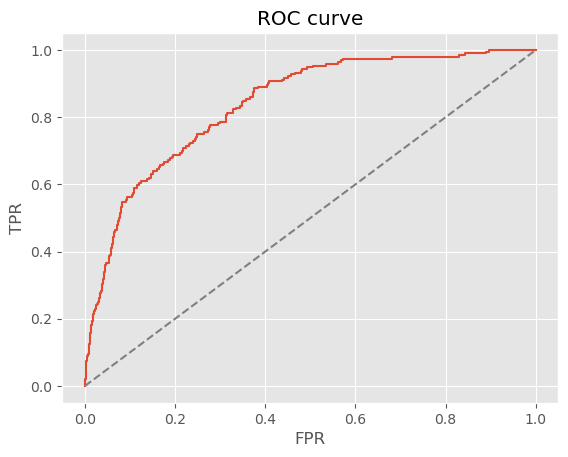

In [586]:
plt.clf()
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC curve')
plt.show()

#### Gradient Boosting Classifier

In [587]:
gb = GradientBoostingClassifier(n_estimators=50, max_depth=5, min_samples_split=500, random_state=42)
gb.fit(X_train, np.ravel(y_train))

GradientBoostingClassifier(max_depth=5, min_samples_split=500, n_estimators=50,
                           random_state=42)

In [588]:
y_score = pd.DataFrame(gb.predict_proba(X_test)[:,1], index=y_test.index, columns=['DelayScore'])

In [589]:
results_df = pd.DataFrame({'HeartDisease': y_test, 'DelayScore': y_score['DelayScore']})

In [590]:
print(metrics.roc_auc_score(results_df['HeartDisease'], results_df['DelayScore']))

0.8552804896947157


In [591]:
fpr, tpr, _ = metrics.roc_curve(results_df['HeartDisease'], results_df['DelayScore'])

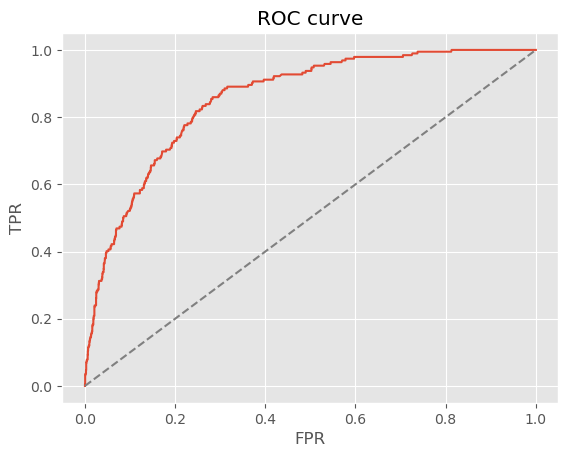

In [592]:
plt.clf()
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC curve')
plt.show()

### FINAL MODEL COMPARISON (Decison Tree vs Random Forest vs Gradient Boosting)

In [593]:
RANDOM_STATE = 42
n_estimators = 50
max_depth = 5

models = [ 
    ('DecisionTree', DecisionTreeClassifier(max_depth=max_depth, random_state=42)),
    ('RandomForest', RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth, random_state=RANDOM_STATE)),
    ('GradientBoosting', GradientBoostingClassifier(n_estimators=n_estimators, max_depth=max_depth, random_state=RANDOM_STATE))
]

ROC AUC Score for DecisionTree: 0.7667133988067565
ROC AUC Score for RandomForest: 0.8341553831551217
ROC AUC Score for GradientBoosting: 0.852498353479002


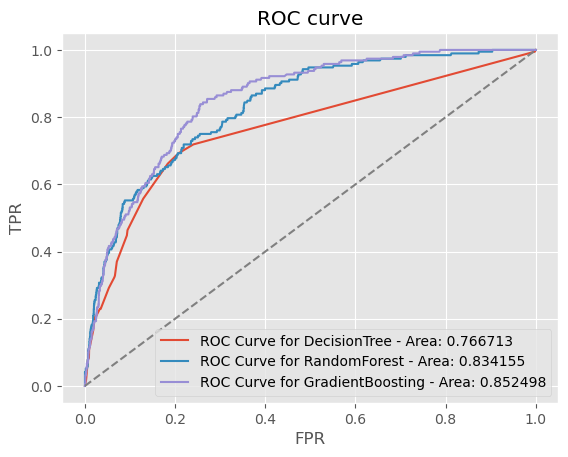

In [594]:
plt.clf()
for model in models:
    model_name = model[0]
    model_instance = model[1]
    model_instance.fit(X_train, np.ravel(y_train))
    predictions = model_instance.predict_proba(X_test)[:,1]
    auc_score = metrics.roc_auc_score(y_test, predictions)
    print('ROC AUC Score for {}: {}'.format(model_name, auc_score))
    fpr, tpr, _ = metrics.roc_curve(y_test, predictions)
    plt.plot(fpr, tpr, label='ROC Curve for {} - Area: {:2f}'.format(model_name, auc_score))
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.legend(loc="lower right")
plt.title('ROC curve')
plt.show()